# Fivetran Data Loaders

This notebook demonstrates how to use PyMC-Marketing's Fivetran data loaders to quickly prepare data for MMM modeling.

If you're using Fivetran to sync data from various sources (like Shopify, Google Ads, Facebook Ads, etc.) and have implemented the corresponding dbt packages, you can leverage our data loaders to streamline your MMM workflow.

## Pre-requisites

1. **Fivetran dbt packages**: Ensure you have the relevant schemas configured:
   - [dbt_shopify](https://github.com/fivetran/dbt_shopify?tab=readme-ov-file#step-3-define-database-and-schema-variables) for e-commerce data
   - [dbt_ad_reporting](https://github.com/fivetran/dbt_ad_reporting?tab=readme-ov-file#union-multiple-connections) for advertising data across multiple platforms

2. **Database queries**: Create queries from your database that follow the Fivetran dbt schema structure. The dbt packages standardize the output format, making it easy to work with data from multiple sources.

## Workflow

Once your data follows the Fivetran dbt schema, you can:
1. Use our data loaders to automatically process and format your data
2. Generate X (media channels) and y (target variable) datasets
3. Quickly train MMM models with minimal data preprocessing

Let's see this in action:

In [ ]:
import pandas as pd

from pymc_marketing.data.fivetran import (
    process_fivetran_ad_reporting,
    process_fivetran_shopify_unique_orders,
)
from pymc_marketing.mmm.builders.yaml import build_mmm_from_yaml
from pymc_marketing.paths import data_dir

## Loading Data from Fivetran dbt Schema

In a real-world scenario, you would typically query your database directly using the Fivetran dbt schema structure. For example:

```python
import pandas as pd
from sqlalchemy import create_engine

Create your database connection
engine = create_engine('your_database_connection_string')

Query the standardized ad reporting table
query = "SELECT * FROM <schema>.ad_reporting__ad_report"
ad_data = pd.read_sql(query, engine)
```

As mentioned, the `ad_reporting__ad_report` table is created by the [dbt_ad_reporting](https://github.com/fivetran/dbt_ad_reporting).

For this demonstration, we're importing a CSV file that follows the exact same schema structure.



In [ ]:
x_data = pd.read_csv(data_dir / "fivetran_examples/ad_report_schema.csv")
x_data.head()

In [3]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   source_relation    16 non-null     object 
 1   date_day           16 non-null     object 
 2   platform           16 non-null     object 
 3   account_id         16 non-null     object 
 4   account_name       16 non-null     object 
 5   campaign_id        16 non-null     object 
 6   campaign_name      16 non-null     object 
 7   ad_group_id        16 non-null     object 
 8   ad_group_name      16 non-null     object 
 9   ad_id              16 non-null     object 
 10  ad_name            16 non-null     object 
 11  clicks             16 non-null     int64  
 12  impressions        16 non-null     int64  
 13  spend              16 non-null     float64
 14  conversions        16 non-null     int64  
 15  conversions_value  16 non-null     float64
dtypes: float64(2), int64(3), obj

## Data Processing
 
From this raw data, we don't need all the columns and granular details. The data is currently in long format (one row per ad/campaign/day combination), but for MMM modeling we need it in wide format with aggregated metrics by platform and date.
 
We can quickly transform this using the `process_fivetran_ad_reporting` function, which will:
- Aggregate the data by platform and date
- Convert from long to wide format
- Keep only the essential columns needed for MMM modeling

> [!NOTE] 
> Remember tables like this one usually contain information from all countries and types of media activities, by consequence the idea should be to filter by the type of media activity (e.g: awareness, retargeting, etc) and country you want to analyse before apply the data helper functions, **otherwise you'll aggregate across all type of media and markets.**

In [4]:
x = process_fivetran_ad_reporting(
    df=x_data,
)
x.head()

,date,facebook_ads_impressions,google_ads_impressions,tiktok_ads_impressions
0,2025-07-10,30000.0,8800.0,21000.0
1,2025-07-11,31000.0,9200.0,22000.0
2,2025-07-12,32000.0,9500.0,0.0


by default we are using impressions, but we could decide to model with **spend** and it's easy to change using a single parameter.

In [5]:
x_spend = process_fivetran_ad_reporting(df=x_data, value_columns="spend")
x_spend.head()

,date,facebook_ads_spend,google_ads_spend,tiktok_ads_spend
0,2025-07-10,381.5,185.75,229.5
1,2025-07-11,396.0,197.50,242.6
2,2025-07-12,410.5,203.80,0.0


You can modify a few things, changing the columns to pivot, the operation to run at the moment of aggregation, among others. You can take a look to the full function here:

In [6]:
process_fivetran_ad_reporting?

Signature:
process_fivetran_ad_reporting(
    df: pandas.core.frame.DataFrame,
    value_columns: str | collections.abc.Sequence[str] = 'impressions',
    *,
    date_col: str = 'date_day',
    platform_col: str = 'platform',
    agg: str = 'sum',
    fill_value: float | None = 0.0,
    include_missing_dates: bool = False,
    freq: str = 'D',
    rename_date_to: str | None = 'date',
) -> pandas.core.frame.DataFrame
Docstring:
Process Fivetran's Ad Reporting schema's.

Compatible with Fivetran's Ad Reporting schema:
- ad_reporting__account_report: Each record represents daily metrics by account
- ad_reporting__campaign_report: Each record represents daily metrics by campaign and account
- ad_reporting__ad_group_report: Each record represents daily metrics by ad group, campaign and account
- ad_reporting__ad_report: Each record represents daily metrics by ad, ad group, campaign and account

The input data is expected to contain at least the following columns: a date column
(default: ``d

All `ad_reporting` tables can provide information about your drivers (media channels) which affect your target metric. But how can you get information from your target?

Currently, Fivetran allows you to get information from Shopify, using [dbt_shopify](https://github.com/fivetran/dbt_shopify?tab=readme-ov-file#step-3-define-database-and-schema-variables). You can use the data loaders to access the `shopify__orders` schema and then transform the dataset to get the output ready for your media mix model.

In [7]:
y_data = pd.read_csv(data_dir / "fivetran_examples/shopify_orders_schema.csv")
y_data.head()

,order_id,user_id,total_discounts,total_discounts_set,total_line_items_price,total_line_items_price_set,total_price,total_price_set,total_tax_set,total_tax,...,count_discount_codes_applied,order_total_shipping_tax,order_tags,order_url_tags,number_of_fulfillments,fulfillment_services,tracking_companies,tracking_numbers,customer_order_seq_number,new_vs_repeat
0,7013,102,19.6,"{""shop_money"":{""amount"":""19.60"",""currency_code...",96.0,"{""shop_money"":{""amount"":""96.00"",""currency_code...",97.03,"{""shop_money"":{""amount"":""97.03"",""currency_code...","{""shop_money"":{""amount"":""8.64"",""currency_code""...",8.64,...,0,1.0,"Welcome, Refund","utm_campaign:summer, utm_source:email",2,deliverr,"USPS, UPS",TRK70131,1,new
1,7014,100,1.2,"{""shop_money"":{""amount"":""1.20"",""currency_code""...",24.0,"{""shop_money"":{""amount"":""24.00"",""currency_code...",28.13,"{""shop_money"":{""amount"":""28.13"",""currency_code...","{""shop_money"":{""amount"":""1.34"",""currency_code""...",1.34,...,2,0.2,"Welcome, Refund","utm_campaign:summer, utm_source:email",2,deliverr,"USPS, UPS","TRK70141, TRK70142",2,repeat
2,7015,101,7.4,"{""shop_money"":{""amount"":""7.40"",""currency_code""...",48.0,"{""shop_money"":{""amount"":""48.00"",""currency_code...",42.63,"{""shop_money"":{""amount"":""42.63"",""currency_code...","{""shop_money"":{""amount"":""2.03"",""currency_code""...",2.03,...,0,0.0,"Promo, Welcome","utm_campaign:summer, utm_source:email",2,manual,"UPS, USPS",TRK70151,3,repeat
3,7016,100,5.0,"{""shop_money"":{""amount"":""5.00"",""currency_code""...",72.0,"{""shop_money"":{""amount"":""72.00"",""currency_code...",74.50,"{""shop_money"":{""amount"":""74.50"",""currency_code...","{""shop_money"":{""amount"":""0.00"",""currency_code""...",0.00,...,0,0.0,"Promo, Refund","utm_campaign:summer, utm_source:email",1,shippo,"USPS, UPS","TRK70161, TRK70162",4,repeat
4,7001,102,13.6,"{""shop_money"":{""amount"":""13.60"",""currency_code...",72.0,"{""shop_money"":{""amount"":""72.00"",""currency_code...",60.40,"{""shop_money"":{""amount"":""60.40"",""currency_code...","{""shop_money"":{""amount"":""0.00"",""currency_code""...",0.00,...,0,0.0,"VIP, Gift","utm_campaign:summer, utm_source:email",1,deliverr,"USPS, FedEx","TRK70011, TRK70012",1,new


In [8]:
y_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 101 columns):
 #    Column                           Non-Null Count  Dtype  
---   ------                           --------------  -----  
 0    order_id                         24 non-null     int64  
 1    user_id                          24 non-null     int64  
 2    total_discounts                  24 non-null     float64
 3    total_discounts_set              24 non-null     object 
 4    total_line_items_price           24 non-null     float64
 5    total_line_items_price_set       24 non-null     object 
 6    total_price                      24 non-null     float64
 7    total_price_set                  24 non-null     object 
 8    total_tax_set                    24 non-null     object 
 9    total_tax                        24 non-null     float64
 10   source_name                      24 non-null     object 
 11   subtotal_price                   24 non-null     float64
 12   has_taxe

As with the previous examples, we're using a CSV file for demonstration purposes. However, in a real-world scenario, you would query the proper schema and data table directly from your Fivetran-connected database to get an output like this one.

```python
# Query the standardized ad reporting table
query = "SELECT * FROM <schema>.shopify__orders"
shopify_data = pd.read_sql(query, engine)
```

Once you get the data from it, you can apply the data loaders in order to simplify your media mix model pipeline.

> [!NOTE] 
> Nevertheless, remember tables like this one usually contain information from all countries or type of transactions, by consequence the idea should be to filter by the type of transactions and country you want to analyse before apply the data helper functions, **otherwise you'll aggregate across all type of transactions and markets.**

In [9]:
y = process_fivetran_shopify_unique_orders(
    df=y_data,
)
y.head()

,date,orders
0,2025-07-10,1
1,2025-07-11,2
2,2025-07-12,4
3,2025-07-13,5
4,2025-07-14,5


You can check the full function to validate all things which you could possibly adjust.

In [10]:
process_fivetran_shopify_unique_orders?

Signature:
process_fivetran_shopify_unique_orders(
    df: pandas.core.frame.DataFrame,
    *,
    date_col: str = 'processed_timestamp',
    order_key_col: str = 'orders_unique_key',
    rename_date_to: str = 'date',
) -> pandas.core.frame.DataFrame
Docstring:
Compute daily unique order counts from a (pre-filtered) Shopify orders dataset.

This function is designed for data following the Fivetran Shopify orders schema
(e.g., ``shopify__orders``). It assumes the input ``df`` is already filtered to
the desired subset (e.g., non-canceled, US-delivery, new-only orders).

Parameters
----------
df
    Input DataFrame following the Shopify orders schema.
date_col
    Column to derive the daily bucket from. Defaults to "processed_timestamp".
order_key_col
    Unique order identifier column. Defaults to "orders_unique_key".
rename_date_to
    Name of the date column in the result. Defaults to "date".

Returns
-------
pd.DataFrame
    A DataFrame with two columns: ``rename_date_to`` and ``order

In [11]:
data = x.merge(y, on="date", how="left").fillna(0)
data.head()

,date,facebook_ads_impressions,google_ads_impressions,tiktok_ads_impressions,orders
0,2025-07-10,30000.0,8800.0,21000.0,1
1,2025-07-11,31000.0,9200.0,22000.0,2
2,2025-07-12,32000.0,9500.0,0.0,4


lternative way to load data using the data pre-processing functions
```python
# data = process_fivetran_ad_reporting(
#     df=x_data,
# ).merge(
#     process_fivetran_shopify_unique_orders(
#     df=y_data,
#     ),
#     on="date",
#     how="left",
# )

# data.head()
```

Once all your data it's prepare, you can train your model 🙌🏻

In [13]:
mmm = build_mmm_from_yaml(
    X=data[
        [
            "date",
            "facebook_ads_impressions",
            "google_ads_impressions",
            "tiktok_ads_impressions",
        ]
    ],
    y=data["orders"],
    config_path=data_dir / "config_files" / "multi_dimensional_fivetran.yml",
)

/Users/carlostrujillo/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/builders/yaml.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[date_column] = pd.to_datetime(X[date_column])


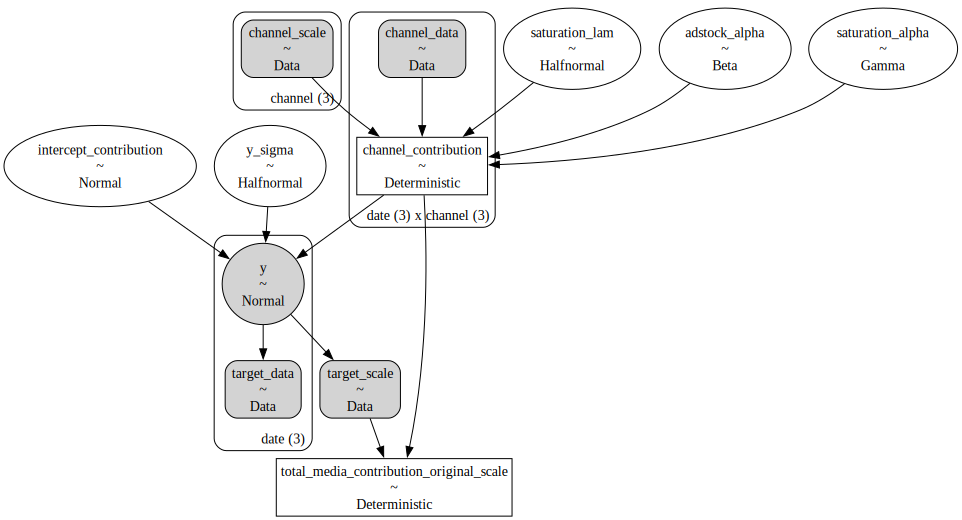

In [14]:
mmm.model.to_graphviz()

In [15]:
mmm.sample_prior_predictive(
    X=data[
        [
            "date",
            "facebook_ads_impressions",
            "google_ads_impressions",
            "tiktok_ads_impressions",
        ]
    ],
    y=data["orders"],
)

Sampling: [adstock_alpha, intercept_contribution, saturation_alpha, saturation_lam, y, y_sigma]


<xarray.Dataset> Size: 24kB
Dimensions:  (date: 3, sample: 500)
Coordinates:
  * date     (date) datetime64[ns] 24B 2025-07-10 2025-07-11 2025-07-12
  * sample   (sample) object 4kB MultiIndex
  * chain    (sample) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    y        (date, sample) float64 12kB 2.442 14.47 10.69 ... 3.808 3.132 5.092
Attributes:
    created_at:                 2025-08-14T19:24:17.732780+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    pymc_marketing_version:     0.15.1

Just like that, you are ready to fit your model and unlock different insights from your data. If you want to know what to explore next, then take a look to the followinc documents:

1. [Multidimensional MMM Example (From Zero to Hero)](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_multidimensional_example.html).
2. [Marketing Mix Models and Budget allocation](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_budget_allocation_example.html).
3. [Risk allocation with Marketing Mix Models](https://www.pymc-marketing.io/en/latest/notebooks/mmm/mmm_allocation_assessment.html).

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Aug 14 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pytensor: 2.31.7

pymc_marketing: 0.15.1
pandas        : 2.3.1

Watermark: 2.5.0

